In [4]:
import pandas as pd
df = pd.read_excel(f"/home/u01130/hachiken_OnlyMe/20240522_課題データ/学習用データ/学習用マーケット・経済指標データ.xlsx",header=6,  sheet_name=1)


In [5]:
# 'A社債系'と'B社債系'の差を計算して新しい行として追加
diff = df['BCBHTRUUIndex'] - df['LCA3TRUUIndex']
new_row = pd.DataFrame({'RISKIndex': [diff.sum()]})
# 新しい列'RISKIndex'を作成
df['RISKIndex'] = diff
# 新しい行を末尾に追加
df = pd.concat([df, new_row], ignore_index=True)

In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


df['Dates'] = pd.to_datetime(df['Dates'])
tdf =  df [['VIXIndex', 
            'RISKIndex','ESIndex','USYC2Y3YIndex','BF020330Index'
            
            ] ].dropna()
features = [
    
    'RISKIndex','ESIndex','USYC2Y3YIndex','BF020330Index'
    
    ]
X = tdf[features]
y = tdf['VIXIndex']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
# 過去60日間のデータを使う
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


Using device: cuda


In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
class CustomModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead,lstm_hidden_size, dropout=0.1):
        super(CustomModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead)
        self.lstm = nn.LSTM(d_model, lstm_hidden_size, batch_first=True)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_hidden_size, 128)
        self.fc2 = nn.Linear(128, 1)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(lstm_hidden_size)

    def forward(self, x):
        # 入力プロジェクション
        x = self.input_projection(x)
        x = x.permute(1, 0, 2)  # 次元を調整してMultiheadAttentionの入力に合わせる
        # MultiheadAttention
        attn_output, _ = self.multihead_attn(x, x, x)
        x = x + attn_output
        x = self.layer_norm1(x)
        x = x.permute(1, 0, 2)  # 次元を元の形式に戻す
        # LSTM層
        lstm_output, _ = self.lstm(x)
        lstm_output = self.layer_norm2(lstm_output)
        # グローバル平均プーリング
        avg_pool_output = self.global_avg_pool(lstm_output.permute(0, 2, 1)).squeeze(-1)
        # 全結合層とDropout
        x = self.dropout(nn.ReLU()(self.fc1(avg_pool_output)))
        output = self.fc2(x)
        return output

In [18]:
input_dim = X.shape[1]
d_model = 256
nhead = 8
lstm_hidden_size = 256
dropout = 0.1

model = CustomModel(input_dim, d_model, nhead, lstm_hidden_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch=X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')

model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch=X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        loss = criterion(output, y_batch)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

model.eval()
predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch).to("cpu")
        predictions.append(output.numpy())
        
predictions = np.concatenate(predictions, axis=0)
y_pred = scaler_y.inverse_transform(predictions)
y_test = scaler_y.inverse_transform(y_test)

Epoch 1/5, Loss: 0.0490
Epoch 2/5, Loss: 0.0100
Epoch 3/5, Loss: 0.0052
Epoch 4/5, Loss: 0.0051
Epoch 5/5, Loss: 0.0042
Test Loss: 0.0029


In [ ]:
def make_flag(predict_vix: np.ndarray):
    df = pd.DataFrame( {"flag_up": [0]*len(predict_vix), "flag_down": [0]*len(predict_vix)})
    for i,vix in enumerate(predict_vix):
        if i > 20:
            if vix > np.mean(predict_vix) and vix > np.percentile(predict_vix[i-21:i-1], 90) and np.mean(predict_vix[i-61:i-1]) > np.mean(predict_vix[i-21:i-1]):
                df.loc[i, "flag_down"] = 1
            if vix > np.mean(predict_vix) + np.std(predict_vix) and vix > np.percentile(predict_vix[i-21:i-1], 25) and np.mean(predict_vix[i-61:i-1]) < np.mean(predict_vix[i-21:i-1]):
                df.loc[i, "flag_up"] = 1
        else:
            if vix > np.mean(predict_vix):
                df.loc[i, "flag_down"] = 1
            if vix > 23:
            # if vix > 22:
                df.loc[i, "flag_up"] = 1
    return df

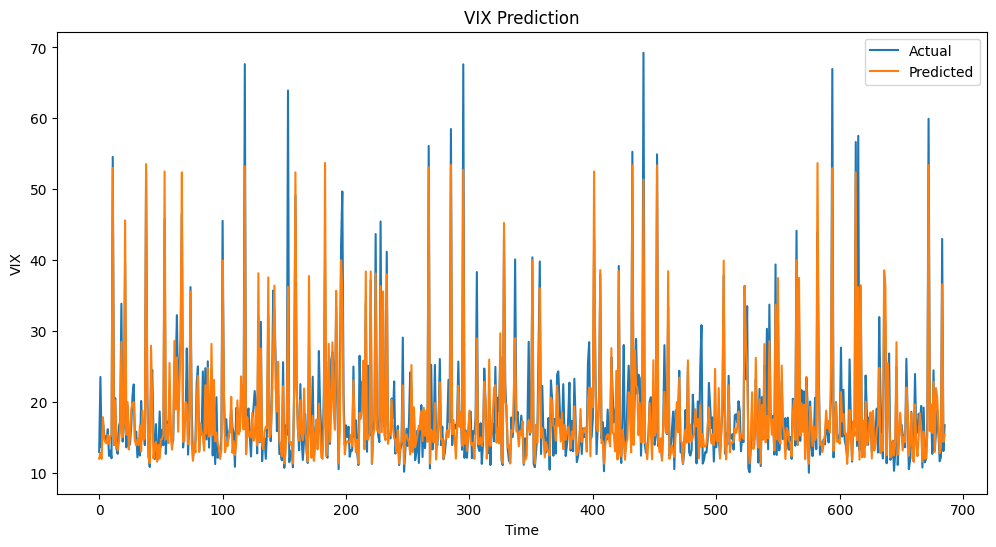

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('VIX Prediction')
plt.xlabel('Time')
plt.ylabel('VIX')
plt.legend()
plt.show()

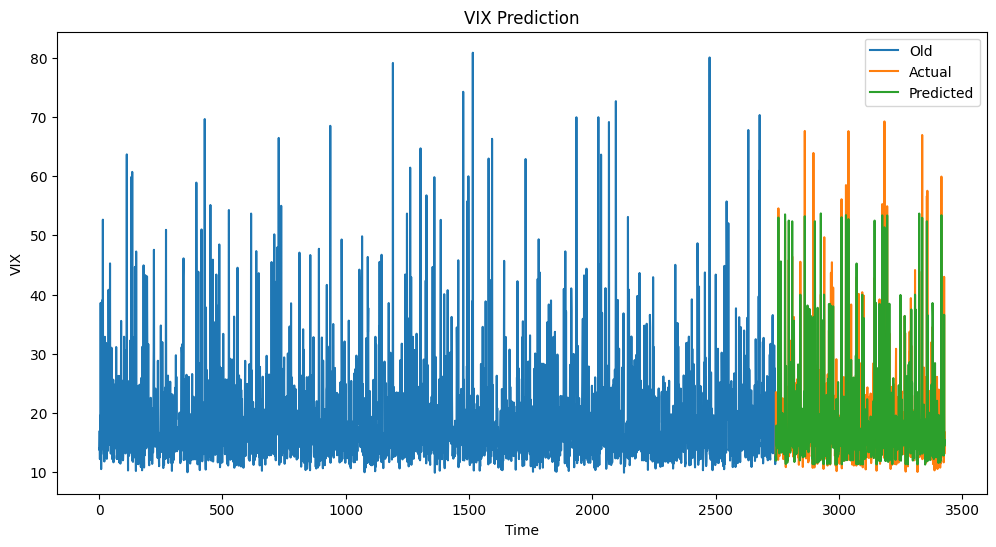

: 

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), scaler_y.inverse_transform(y_train), label='Old')
plt.plot(range(len(y_train), len(y_train)+ len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_train), len(y_train)+ len(y_test)), y_pred, label='Predicted')
plt.title('VIX Prediction')
plt.xlabel('Time')
plt.ylabel('VIX')
plt.legend()
plt.show()